## Defining our Multi-layer Perceptron (MLP) and Convolutional Neural Network (CNN)

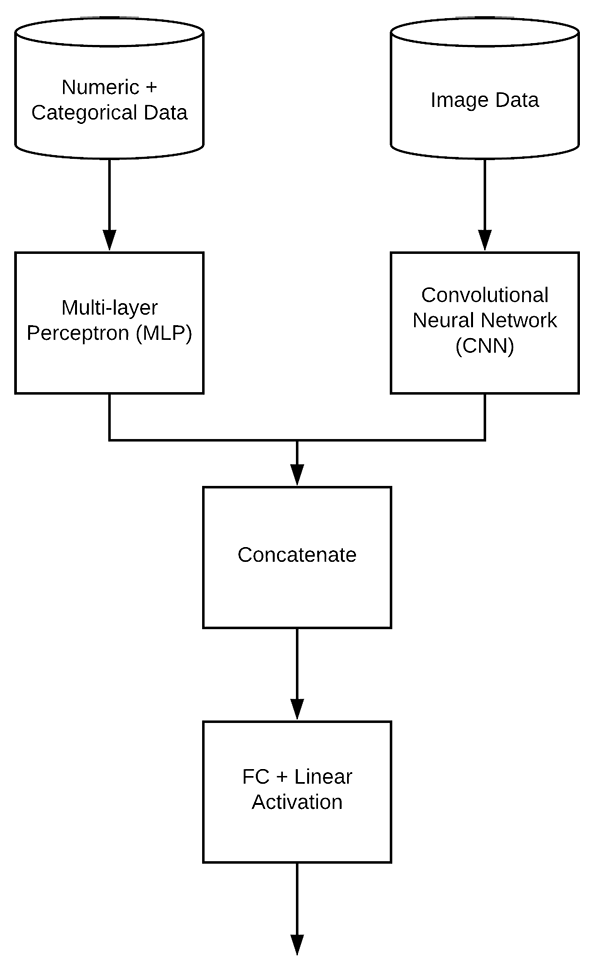

In [8]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def create_mlp(dim,regress = False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    
    # Return model
    return model

def create_cnn(width,height,depth,filters = (16,32,64),regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
            
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)
        
        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)
        
        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)
        
        # construct the CNN
        model = Model(inputs, x)
        
        # return the CNN
        return model

In [ ]:
mlp = models.create_mlp(trainAttrX.shape[1], regress=False)
cnn = models.create_cnn(64, 64, 3, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# train the model
print("[INFO] training model...")
model.fit([trainAttrX, trainImagesX], trainY,validation_data=([testAttrX, testImagesX], testY),epochs=200, batch_size=8)

# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])